In [14]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline   
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
)
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix

from xgboost import XGBClassifier


import matplotlib.pyplot as plt
import plotly.express as px

# Import dataset

In [15]:
df = pd.read_csv('../data/raw/conversion_data_train.csv', sep=',')

In [16]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [17]:
df.shape

(284580, 6)

# Peprocessing

In [18]:
target = "converted"
X = df.drop(columns=[target])
y = df[target].astype(int)

categorical_features = [c for c in X.columns if X[c].dtype == "object"]
numeric_features = [c for c in X.columns if c not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numeric_features),
        ("cat", categorical_preprocessor, categorical_features),
    ],
    remainder="drop",
)

# XGBoost

In [19]:
xgb_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        random_state=0,
        eval_metric="logloss",   # évite warning
        n_jobs=-1
    ))
])

param_grid = {
    "clf__max_depth": [3, 4, 6],
    "clf__min_child_weight": [1, 2, 4],
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid_xgb = GridSearchCV(
    xgb_pipe,
    param_grid=param_grid,
    scoring="f1",     # important : metric du challenge
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_xgb.fit(X_train, y_train)

print("Best params:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__min_child_weight': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


# Evaluation du modèle

In [20]:
def evaluate_model(name, pipe, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    metrics = {
        "model": name,
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }
    return metrics, y_pred, y_proba

In [21]:
xgb_metrics, ypred_xgb, yproba_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test)

,model,f1,precision,recall,roc_auc
0,XGBoost,0.7691,0.8528,0.7004,0.9865


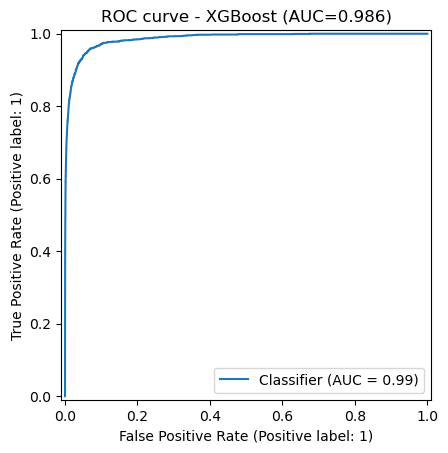

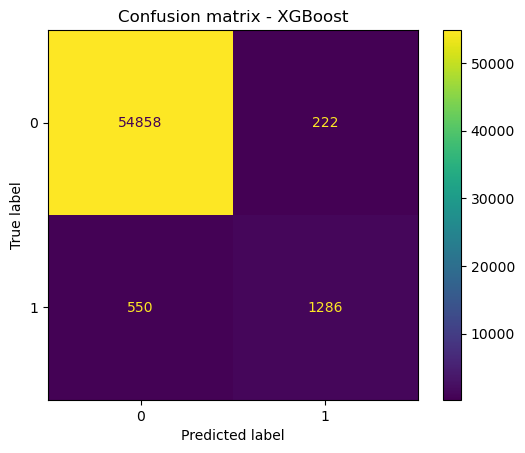

In [22]:
results_df = pd.DataFrame([xgb_metrics])
display(results_df.round(4))

RocCurveDisplay.from_predictions(y_test, yproba_xgb)
plt.title(f"ROC curve - {xgb_metrics['model']} (AUC={xgb_metrics['roc_auc']:.3f})")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, ypred_xgb, values_format="d")
plt.title(f"Confusion matrix - {xgb_metrics['model']}")
plt.show()

## Sauvegarde des logs

In [23]:
results_path = "../data/outputs/model_results.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)

row = xgb_metrics.copy()
row["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

row_df = pd.DataFrame([row])

if os.path.exists(results_path):
    row_df.to_csv(results_path, mode="a", header=False, index=False)
else:
    row_df.to_csv(results_path, mode="w", header=True, index=False)

print(f"Résultats ajoutés à {results_path}")

Résultats ajoutés à ../data/outputs/model_results.csv


# Retraining sur intégralité du dataset

In [24]:
target = "converted"
X_full = df.drop(columns=[target])
y_full = df[target].astype(int)

xgb_pipe.fit(X_full, y_full)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'new_user',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'source'])])),
                ('clf',
                 XGBClassifier(base_scor...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=0, ...))])

## Chargement des données non-labellisée

In [25]:
df_unlabeled = pd.read_csv("../data/raw/conversion_data_test.csv")

feature_cols = X_full.columns.tolist()
df_unlabeled = df_unlabeled[feature_cols]

y_proba = xgb_pipe.predict_proba(df_unlabeled)[:, 1]
y_pred  = xgb_pipe.predict(df_unlabeled)

In [26]:
submission = pd.DataFrame({
    "id": np.arange(len(df_unlabeled)),
    "converted": y_pred
})
submission.to_csv("../data/outputs/conversion_data_test_predictions_xgboost.csv", index=False)

In [28]:
dist = submission["converted"].value_counts().sort_index().reset_index()
dist.columns = ["converted", "count"]
dist["label"] = dist["converted"].map({0: "Non converti (0)", 1: "Converti (1)"})

fig = px.pie(
    dist,
    names="label",
    values="count",
    title="Distribution des prédictions",
)

fig.update_traces(textinfo="percent+value")  # % + effectif

fig.update_layout(
    width=650, height=650,                 # carré
    legend_title_text="Classe prédite",
    margin=dict(t=80, l=20, r=20, b=20),
)
fig.show()